# Predictions of procurement data using language model
Roberta model trained on description of notices from dataset available at s3://d-ew1-ted-ai-experiments-data/CPVs/202302/20230214-dataset-eu-contract-notices.csv.
## Load procurement dataset
Dataset available at s3://d-ew1-ted-ai-experiments-data/CPVs/202303/20230301-procurement_data_for_eu_notices.csv

In [1]:
from ast import literal_eval
import pandas as pd


df = pd.read_csv('procurements_data/20230301-procurement_data_for_eu_notices.csv', dtype={'main_cpv': str}, converters={"additional_cpvs": literal_eval, "procurement_data": literal_eval})
df.tail()

id      notice_type  main_cpv additional_cpvs  \
3818  2020/S 106-255487  Contract notice  34113200              []   
3819  2022/S 125-351443  Contract notice  48461000              []   
3820  2022/S 101-278437  Contract notice  63500000              []   
3821  2018/S 052-114411  Contract notice  79300000              []   
3822  2019/S 118-288646  Contract notice  31682210              []   

                                         etendering_url  \
3818  https://etendering.ted.europa.eu/cft/cft-displ...   
3819  https://etendering.ted.europa.eu/cft/cft-displ...   
3820  https://etendering.ted.europa.eu/cft/cft-displ...   
3821  https://etendering.ted.europa.eu/cft/cft-displ...   
3822  https://etendering.ted.europa.eu/cft/cft-displ...   

                                       procurement_data  
3818  [1 TENDERING SPECIFICATIONS Call for tenders E...  
3819  [ORDER NOEUROPEAN COMMISSION JOINT RESEARCH CE...  
3820  [22ETF02 Tender specifications Regional SEET P...  
3821  [MODEL TERMS OF REFERENCE TENDER SPECIFICATION...  
3822  [index.php NE.45.2301.A.022 ND.45.1001011.A.01...

## Predictions on procurement data
Model used corresponds to the Rank 1 one described in : https://citnet.tech.ec.europa.eu/CITnet/confluence/display/AITED/2.3.3+Multi-label+classification+of+CPV+divisions

In [35]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification


tokenizer = AutoTokenizer.from_pretrained("./roberta-base", local_files_only=True)
model = AutoModelForSequenceClassification.from_pretrained("./roberta-base")

In [40]:
import re
import torch
import numpy as np

labels = ['85', '44', '50', '80', '73', '45', '71', '79', '90', '30', '35', '33', '55', '72', '48', '38', '09', '75', '66', '64', '42', '34', '60', '92', '39', '31', '98', '51', '32', '65', '77', '22', '63', '15', '70', '18', '03', '24', '43', '19', '41', '37', '14', '16', '76']
id2label = {0: '85', 1: '44', 2: '50', 3: '80', 4: '73', 5: '45', 6: '71', 7: '79', 8: '90', 9: '30', 10: '35', 11: '33', 12: '55', 13: '72', 14: '48', 15: '38', 16: '09', 17: '75', 18: '66', 19: '64', 20: '42', 21: '34', 22: '60', 23: '92', 24: '39', 25: '31', 26: '98', 27: '51', 28: '32', 29: '65', 30: '77', 31: '22', 32: '63', 33: '15', 34: '70', 35: '18', 36: '03', 37: '24', 38: '43', 39: '19', 40: '41', 41: '37', 42: '14', 43: '16', 44: '76'}

all_results = []
for index, row in df.iterrows():
    procurement_data = row["procurement_data"]
    merged_procurement_data = " ".join(procurement_data)
    merged_procurement_data = re.sub('http://\S+|https://\S+', '', merged_procurement_data)
    splitted_by_dot = list(filter(None, merged_procurement_data.split(".")))
    result_row = []
    for element in splitted_by_dot:

        if len(element) < 100 or len(element) > 510:
            continue
        
        encoded_input = tokenizer(element, return_tensors='pt', padding=True)

        results = model(**encoded_input)
        logits = results.logits
        sigmoid = torch.nn.Sigmoid()
        probs = sigmoid(logits.squeeze().cpu())
        predictions = np.zeros(probs.shape)
        predictions[np.where(probs >= 0.75)] = 1
        predicted_labels = [id2label[idx] for idx, label in enumerate(predictions) if label == 1.0]
        if predicted_labels:
            for lab in predicted_labels:
                result_row.append(lab)

    all_results.append(set(result_row))




In [41]:
print(all_results)

[{'66', '72', '33', '75', '85', '71', '73', '79'}, {'63', '80', '71', '73', '79'}, {'48', '50', '66', '30', '55', '72', '63', '80', '75', '71', '73', '90', '60', '79'}, {'35', '66', '72', '80', '75', '71', '73', '79'}, {'50', '31', '72', '38', '80', '71', '73', '45', '90', '79'}, {'66', '72', '80', '75', '71', '73', '90', '79'}, {'35', '66', '34', '72', '63', '60', '80', '75', '71', '73', '90', '79', '32'}, {'66', '39', '80', '75', '71', '73', '90', '55', '79'}, {'48', '66', '30', '72', '63', '60', '75', '71', '73', '79'}, {'48', '50', '66', '64', '30', '72', '73', '71', '60', '79', '32'}, {'66', '30', '72', '75', '71', '73', '79'}, {'72', '80', '75', '71', '73', '90', '79'}, {'66', '72', '63', '80', '75', '71', '55', '79'}, {'50', '64', '63', '38', '75', '71', '73', '42', '79'}, {'45', '79', '71', '60'}, {'35', '66', '55', '72', '80', '60', '75', '71', '73', '90', '79', '32'}, {'48', '50', '30', '72', '63', '80', '42', '71', '39', '79', '32'}, {'79'}, {'66', '72', '80', '71', '73', '9

## Analyse results

In [50]:
import copy
df_copied = copy.deepcopy(df)
df_copied["predicted"] = all_results
df_copied.head()

id      notice_type  main_cpv additional_cpvs  \
0  2017/S 102-203726  Contract notice  85100000              []   
1  2014/S 138-246767  Contract notice  80580000              []   
2  2017/S 164-337354  Contract notice  80600000              []   
3  2016/S 070-121405  Contract notice  73000000              []   
4  2022/S 084-222910  Contract notice  71000000              []   

                                      etendering_url  \
0  https://etendering.ted.europa.eu/cft/cft-displ...   
1  https://etendering.ted.europa.eu/cft/cft-displ...   
2  https://etendering.ted.europa.eu/cft/cft-displ...   
3  https://etendering.ted.europa.eu/cft/cft-displ...   
4  https://etendering.ted.europa.eu/cft/cft-displ...   

                                    procurement_data  \
0  [Tender Specificationsopen callreview july 201...   
1  [Annex12013POEJ4.DOCX ANNEX 1 2014/PO/EJ/10 Pa...   
2  [4102cahierdeschargesopenprocedureenjuly2010.d...   
3  [4102cahierdeschargesopenprocedureenjuly2010.d...   
4  [European Commission DG Joint Research Centre ...   

                                           predicted  
0                   {66, 72, 33, 75, 85, 71, 73, 79}  
1                               {63, 80, 71, 73, 79}  
2  {48, 50, 66, 30, 55, 72, 63, 80, 75, 71, 73, 9...  
3                   {35, 66, 72, 80, 75, 71, 73, 79}  
4           {50, 31, 72, 38, 80, 71, 73, 45, 90, 79}

In [51]:
df_copied = df_copied.drop(['notice_type', 'etendering_url', 'procurement_data'], axis = 1)

In [52]:
df_copied.to_csv("language_model_procurement_data_actual_vs_predicted.csv")

In [2]:
import pandas as pd
from ast import literal_eval

df_copied = pd.read_csv("language_model_procurement_data_actual_vs_predicted.csv", dtype={'main_cpv': str}, converters={"additional_cpvs": literal_eval}, index_col=0)
for index, row in df_copied.iterrows():
    row_value = row["predicted"]
    row_value = row_value.replace("{", "")
    row_value = row_value.replace("}", "")
    row_value = row_value.replace("'", "")
    row_value = row_value.replace("set()", "")
    row_value = row_value.split(",")
    new_result = [x.strip() for x in row_value]
    row["predicted"] = new_result


In [3]:
df_copied['main_cpv'] = df_copied['main_cpv'].apply(lambda x: x[:2])
# Merge additional_cpvs and main_cpv into all_cpvs
all_cpvs = []
df_copied["all_cpvs"] = ""

for ind, row in df_copied.iterrows():
  main_cpv = row['main_cpv']
  additionnal_cpvs = row['additional_cpvs']
  cpvs_rows = []
  if main_cpv:
    cpvs_rows.append(main_cpv)
  if additionnal_cpvs:
    cpvs_rows.extend(row['additional_cpvs'])

  cpv_to_add = []

  for cpv in cpvs_rows:
    if cpv:
      division_cpv = cpv[:2]
      if division_cpv not in cpv_to_add:
        cpv_to_add.append(division_cpv)
      if division_cpv not in all_cpvs:
        all_cpvs.append(division_cpv)
  row["all_cpvs"] = cpv_to_add

df_copied.head(5)

id main_cpv additional_cpvs  \
0  2017/S 102-203726       85              []   
1  2014/S 138-246767       80              []   
2  2017/S 164-337354       80              []   
3  2016/S 070-121405       73              []   
4  2022/S 084-222910       71              []   

                                           predicted all_cpvs  
0                   [66, 72, 33, 75, 85, 71, 73, 79]     [85]  
1                               [63, 80, 71, 73, 79]     [80]  
2  [48, 50, 66, 30, 55, 72, 63, 80, 75, 71, 73, 9...     [80]  
3                   [35, 66, 72, 80, 75, 71, 73, 79]     [73]  
4           [50, 31, 72, 38, 80, 71, 73, 45, 90, 79]     [71]

In [4]:
proportion_division_in_prediction = []
for ind, row in df_copied.iterrows():
    local_result = 0
    number_cpvs = len(row["all_cpvs"])
    for individual_cpv in row["all_cpvs"]:
        if individual_cpv in row["predicted"]:
            local_result += 1
    
    proportion_division_in_prediction.append(local_result/number_cpvs)
    

In [5]:
df_copied["prop_div_in_pred"] = proportion_division_in_prediction
df_copied.head()

id main_cpv additional_cpvs  \
0  2017/S 102-203726       85              []   
1  2014/S 138-246767       80              []   
2  2017/S 164-337354       80              []   
3  2016/S 070-121405       73              []   
4  2022/S 084-222910       71              []   

                                           predicted all_cpvs  \
0                   [66, 72, 33, 75, 85, 71, 73, 79]     [85]   
1                               [63, 80, 71, 73, 79]     [80]   
2  [48, 50, 66, 30, 55, 72, 63, 80, 75, 71, 73, 9...     [80]   
3                   [35, 66, 72, 80, 75, 71, 73, 79]     [73]   
4           [50, 31, 72, 38, 80, 71, 73, 45, 90, 79]     [71]   

   prop_div_in_pred  
0               1.0  
1               1.0  
2               1.0  
3               1.0  
4               1.0

In [6]:
value_count = dict(df_copied['prop_div_in_pred'].value_counts())
ordered_keys_value_count = dict(sorted(value_count.items()))
print(ordered_keys_value_count)

{0.0: 223, 0.3333333333333333: 2, 0.5: 5, 0.6: 1, 0.6666666666666666: 5, 0.75: 1, 0.8: 2, 1.0: 3584}


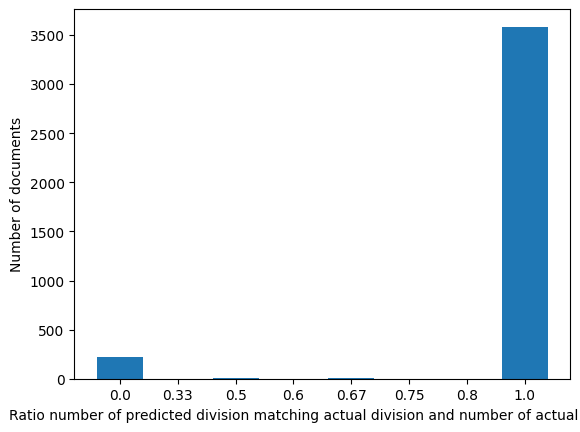

In [7]:
import matplotlib
import matplotlib.pyplot as plt


font = {'size': 10}
matplotlib.rc('font', **font)

x_axis = list(ordered_keys_value_count.keys())
x_axis = [round(x, 2) for x in x_axis]
plt.bar(range(len(ordered_keys_value_count)), ordered_keys_value_count.values(), tick_label=x_axis)
plt.ylabel("Number of documents")
plt.xlabel("Ratio number of predicted division matching actual division and number of actual division")
plt.show()


In [8]:
number_of_wrong_division = []
for ind, row in df_copied.iterrows():
    local_result = 0
    for individual_cpv in row["predicted"]:
        if individual_cpv not in row["all_cpvs"]:
            local_result += 1
    
    number_of_wrong_division.append(local_result)
    
df_copied["number_wrong_predicted_division"] = number_of_wrong_division

df_copied.head()

id main_cpv additional_cpvs  \
0  2017/S 102-203726       85              []   
1  2014/S 138-246767       80              []   
2  2017/S 164-337354       80              []   
3  2016/S 070-121405       73              []   
4  2022/S 084-222910       71              []   

                                           predicted all_cpvs  \
0                   [66, 72, 33, 75, 85, 71, 73, 79]     [85]   
1                               [63, 80, 71, 73, 79]     [80]   
2  [48, 50, 66, 30, 55, 72, 63, 80, 75, 71, 73, 9...     [80]   
3                   [35, 66, 72, 80, 75, 71, 73, 79]     [73]   
4           [50, 31, 72, 38, 80, 71, 73, 45, 90, 79]     [71]   

   prop_div_in_pred  number_wrong_predicted_division  
0               1.0                                7  
1               1.0                                4  
2               1.0                               13  
3               1.0                                7  
4               1.0                                9

{0: 1, 1: 37, 2: 52, 3: 62, 4: 117, 5: 175, 6: 355, 7: 574, 8: 575, 9: 559, 10: 451, 11: 313, 12: 175, 13: 128, 14: 86, 15: 47, 16: 30, 17: 20, 18: 21, 19: 18, 20: 10, 21: 8, 22: 1, 23: 4, 24: 1, 27: 3}


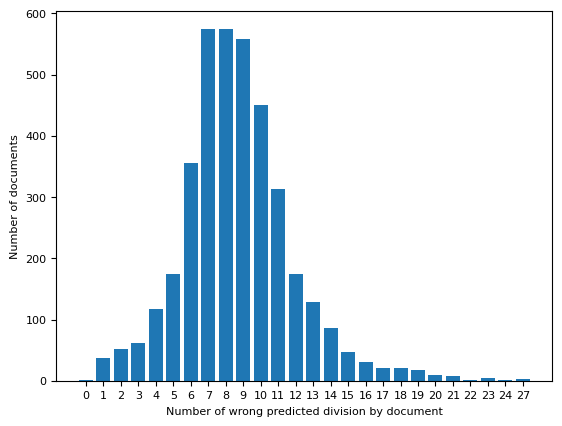

In [9]:
value_count = dict(df_copied['number_wrong_predicted_division'].value_counts())
ordered_keys_value_count = dict(sorted(value_count.items()))
print(ordered_keys_value_count)
font = {'size': 8}
matplotlib.rc('font', **font)

x_axis = list(ordered_keys_value_count.keys())
x_axis = [round(x, 2) for x in x_axis]
plt.bar(range(len(ordered_keys_value_count)), ordered_keys_value_count.values(), tick_label=x_axis)
plt.ylabel("Number of documents")
plt.xlabel("Number of wrong predicted division by document")
plt.show()

In [10]:
wrong_divisions = []
for ind, row in df_copied.iterrows():
    local_result = []
    for individual_cpv in row["predicted"]:
        if individual_cpv not in row["all_cpvs"]:
            local_result.append(individual_cpv)
    
    wrong_divisions.append(local_result)
    
df_copied["wrong_divisions"] = wrong_divisions
df_copied.head()


id main_cpv additional_cpvs  \
0  2017/S 102-203726       85              []   
1  2014/S 138-246767       80              []   
2  2017/S 164-337354       80              []   
3  2016/S 070-121405       73              []   
4  2022/S 084-222910       71              []   

                                           predicted all_cpvs  \
0                   [66, 72, 33, 75, 85, 71, 73, 79]     [85]   
1                               [63, 80, 71, 73, 79]     [80]   
2  [48, 50, 66, 30, 55, 72, 63, 80, 75, 71, 73, 9...     [80]   
3                   [35, 66, 72, 80, 75, 71, 73, 79]     [73]   
4           [50, 31, 72, 38, 80, 71, 73, 45, 90, 79]     [71]   

   prop_div_in_pred  number_wrong_predicted_division  \
0               1.0                                7   
1               1.0                                4   
2               1.0                               13   
3               1.0                                7   
4               1.0                                9   

                                     wrong_divisions  
0                       [66, 72, 33, 75, 71, 73, 79]  
1                                   [63, 71, 73, 79]  
2  [48, 50, 66, 30, 55, 72, 63, 75, 71, 73, 90, 6...  
3                       [35, 66, 72, 80, 75, 71, 79]  
4               [50, 31, 72, 38, 80, 73, 45, 90, 79]

In [11]:
import matplotlib
import matplotlib.pyplot as plt

font = {'size': 22}
matplotlib.rc('font', **font)


def create_barplot_from_dict(dictionary, threshold):
    plt.figure(figsize=(24,10))
    plt.bar(dictionary.keys(), dictionary.values(), color='b', edgecolor='k', alpha=0.65)
    if threshold:
        plt.axhline(y=threshold,linewidth=2, color='r')
    plt.xticks(rotation=90)



def count_elements_in_dataframe_from_columns(df, list_column_names):
    found_aggregation = dict()
    for _, row in df.iterrows():
        for column_name in list_column_names:
            if row[column_name]:
                if column_name not in found_aggregation:
                    found_aggregation[column_name] = 1
                else:
                    found_aggregation[column_name] = found_aggregation[column_name] + 1

    return found_aggregation

In [12]:
number_wrong_division_prediction = {}
for ind, row in df_copied.iterrows():
    for individual_cpv in row["wrong_divisions"]:
        if individual_cpv not in number_wrong_division_prediction.keys():
            number_wrong_division_prediction[individual_cpv] = 1
        else:
            number_wrong_division_prediction[individual_cpv] += 1

print(number_wrong_division_prediction)

{'66': 2883, '72': 2911, '33': 250, '75': 2773, '71': 3537, '73': 2426, '79': 2652, '63': 1493, '48': 1319, '50': 518, '30': 1181, '55': 656, '90': 2048, '60': 739, '35': 374, '80': 2208, '31': 188, '38': 298, '45': 1074, '34': 525, '32': 642, '39': 424, '64': 541, '42': 222, '09': 150, '85': 390, '77': 151, '22': 170, '44': 55, '92': 252, '70': 82, '15': 24, '': 13, '98': 9, '18': 24}


Text(0.5, 0, 'CPV division')

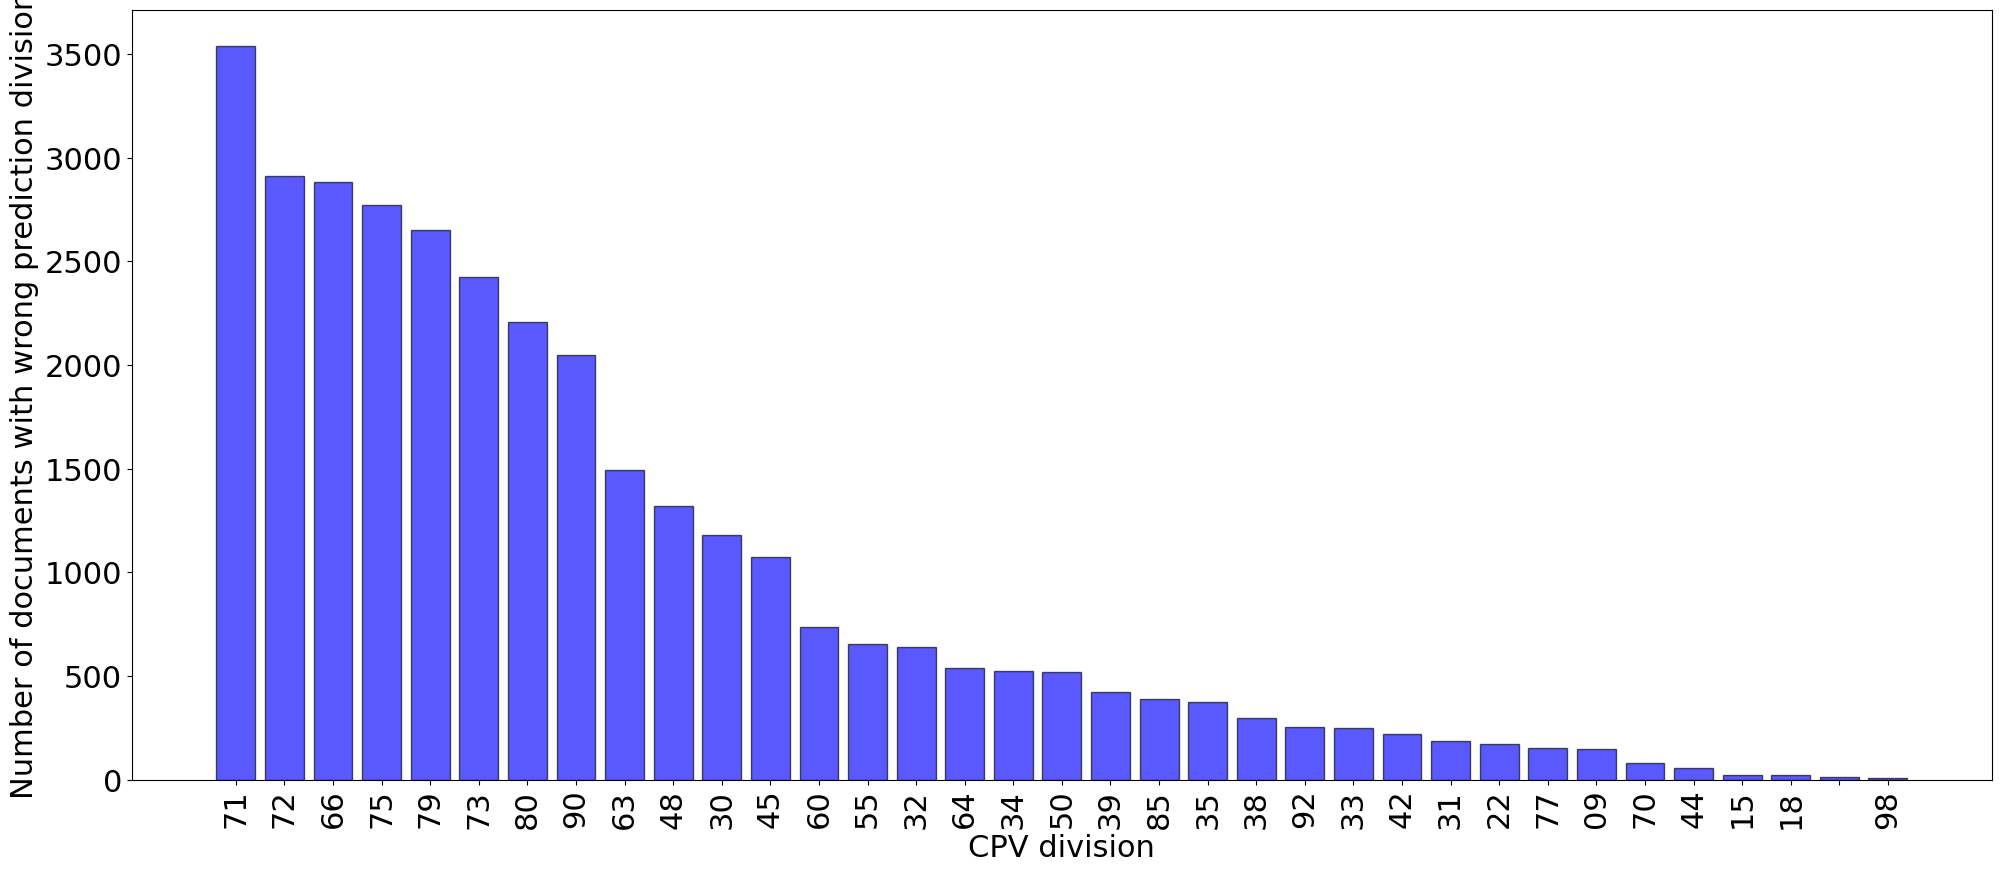

In [13]:
sorted_count_of_cpvs = dict(sorted(number_wrong_division_prediction.items(), key=lambda x:x[1], reverse=True))
create_barplot_from_dict(sorted_count_of_cpvs, None)
plt.ylabel("Number of documents with wrong prediction division")
plt.xlabel("CPV division")

In [15]:
sorted_count_of_cpvs

{'71': 3537,
 '72': 2911,
 '66': 2883,
 '75': 2773,
 '79': 2652,
 '73': 2426,
 '80': 2208,
 '90': 2048,
 '63': 1493,
 '48': 1319,
 '30': 1181,
 '45': 1074,
 '60': 739,
 '55': 656,
 '32': 642,
 '64': 541,
 '34': 525,
 '50': 518,
 '39': 424,
 '85': 390,
 '35': 374,
 '38': 298,
 '92': 252,
 '33': 250,
 '42': 222,
 '31': 188,
 '22': 170,
 '77': 151,
 '09': 150,
 '70': 82,
 '44': 55,
 '15': 24,
 '18': 24,
 '': 13,
 '98': 9}

In [14]:
total_wrong = 0
for key, value in sorted_count_of_cpvs.items():
    total_wrong += value

print(f"Total wrong predictions: {total_wrong}")

Total wrong predictions: 33202


In [67]:
df_copied.to_csv("procurement_data_with_language_model_predictions.csv")